# GPU configuration and code initialisation

## Importing libraries and pre-processing data

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import hashlib

# Check GPU availability and enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

# Use mixed precision for faster training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Function to load and preprocess images
def load_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img).astype('float32') / 127.5 - 1.0  # Normalize to [-1, 1]
    return img_array

# Hash the password to generate a key
def hash_key(password):
    hashed = hashlib.sha256(password.encode()).hexdigest()
    seed = int(hashed, 16) % (2**32)  # Use part of the hash as a seed
    return seed

# Build an autoencoder model optimized for GPU
def build_autoencoder(input_shape=(128, 128, 3)):
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded_img = layers.Conv2D(3, (3, 3), activation='linear', padding='same', dtype='float32')(x)  # Ensure float32

    autoencoder = models.Model(input_img, decoded_img)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

GPU memory growth enabled


## Encryption and decryption function definition

In [ ]:
# Encrypt an image using a password-based key
def encrypt_image(autoencoder, image, password):
    key = hash_key(password)  # Hash the password to generate a seed
    encoder = models.Model(autoencoder.input, autoencoder.layers[4].output)  # Extract encoder
    latent_representation = encoder.predict(np.expand_dims(image, axis=0))
    np.random.seed(key)  # Use hashed key to seed randomness
    noise = np.random.normal(0, 1, latent_representation.shape)
    encrypted_image = latent_representation + noise
    return encrypted_image

# Decrypt an image using the same password-based key
def decrypt_image(autoencoder, encrypted_image, password):
    key = hash_key(password)  # Hash the password to generate the same seed
    np.random.seed(key)  # Use the same hashed key
    noise = np.random.normal(0, 1, encrypted_image.shape)
    decrypted_representation = encrypted_image - noise

    # Get the decoder part of the autoencoder
    decoder_input = autoencoder.layers[5].input  # Input to the decoder part
    decoder_output = autoencoder.layers[-1].output  # Output of the decoder part
    decoder = models.Model(decoder_input, decoder_output)

    # Pass the decrypted representation to the decoder to reconstruct the image
    return decoder.predict(decrypted_representation)


## Sharpening filter

In [ ]:
from scipy.ndimage import convolve
import numpy as np

# Apply a sharpening filter to the image
def apply_sharpening_filter(image):
    # Define a sharpening kernel
    sharpening_kernel = np.array([[0, -1, 0],
                                   [-1, 5, -1],
                                   [0, -1, 0]])
    # Apply convolution to each channel separately
    if image.ndim == 3:  # For RGB images
        sharpened_image = np.zeros_like(image)
        for channel in range(image.shape[2]):
            sharpened_image[:, :, channel] = convolve(image[:, :, channel], sharpening_kernel)
    else:  # For grayscale images
        sharpened_image = convolve(image, sharpening_kernel)

    # Clip values to ensure they remain in the valid range
    sharpened_image = np.clip(sharpened_image, 0, 1)
    return sharpened_image

# Machine learning modal

## Dataset processing

In [ ]:
import tensorflow_datasets as tfds

# Load the dataset
def load_high_quality_data(dataset_name="imagenette", image_size=(128, 128), batch_size=128):
    dataset, info = tfds.load(dataset_name, with_info=True, as_supervised=True)
    num_classes = info.features['label'].num_classes

    def preprocess(image, label):
        # Resize and normalize images to [-1, 1]
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 127.5 - 1.0
        return image, image

    # Prepare training and test datasetsllll ll ll l
    train_dataset = dataset['train'].map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = dataset['validation'].map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset, num_classes

# Load the dataset
train_dataset, test_dataset, num_classes = load_high_quality_data("imagenette", image_size=(128, 128))

# Print dataset details
print(f"Number of classes: {num_classes}")
print(f"Sample training batch shape: {next(iter(train_dataset))[0].shape}")

Number of classes: 10
Sample training batch shape: (128, 128, 128, 3)


## Modal Build

In [ ]:
# Build the autoencoder model
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,755 (1.14 MB)

 Trainable params: 298,755 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

## Training the modal

In [ ]:
# Train the autoencoder
autoencoder.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - loss: 0.2352 - val_loss: 0.1277
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 87s 433ms/step - loss: 0.1233 - val_loss: 0.1141
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 437ms/step - loss: 0.1119 - val_loss: 0.1067
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 46s 597ms/step - loss: 0.1049 - val_loss: 0.1017
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 462ms/step - loss: 0.1008 - val_loss: 0.1018
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 422ms/step - loss: 0.0994 - val_loss: 0.0963
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 463ms/step - loss: 0.0956 - val_loss: 0.0992
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 630ms/step - loss: 0.0946 - val_loss: 0.0941
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 34s 433ms/step - loss: 0.0939 - val_loss: 0.0971
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step - loss: 0.0915 - val_loss: 0.0879


## image testing

In [ ]:
# Load an image
image_path = "/content/eagle.jpg"
original_image = load_image(image_path)

# Encrypt the image with a password
password = "securepassword"
encrypted_image = encrypt_image(autoencoder, original_image, password)

# Decrypt the image using the same password
decrypted_image = decrypt_image(autoencoder, encrypted_image, password)

# Rescale decrypted image to [0, 1] for sharpening
decrypted_image_rescaled = np.clip((decrypted_image[0] + 1) / 2, 0, 1)

# Apply the sharpening filter
sharpened_image = apply_sharpening_filter(decrypted_image_rescaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


## visualising the result

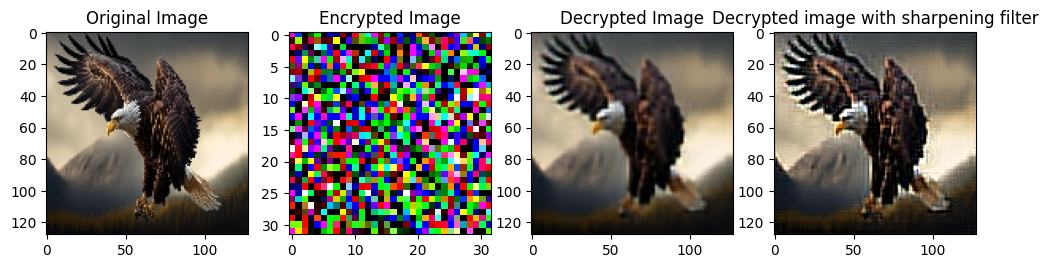

In [ ]:
# Visualize results
plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow((original_image + 1) / 2)  # Convert back to [0, 1] for display

# Encrypted Image (Combined Channels)
encrypted_image_combined = encrypted_image[0]  # Remove batch dimension
# If encrypted_image has more than 3 channels, select the first 3
if encrypted_image_combined.shape[-1] > 3:
    encrypted_image_combined = encrypted_image_combined[:, :, :3]
plt.subplot(1, 4, 2)
plt.title('Encrypted Image')
plt.imshow(encrypted_image_combined)

# Decrypted Image
plt.subplot(1, 4, 3)
plt.title('Decrypted Image')
plt.imshow((decrypted_image[0] + 1) / 2)  # Convert back to [0, 1]

# Decrypted image with sharpening filter
plt.subplot(1, 4, 4)
plt.title('Decrypted image with sharpening filter')
plt.imshow(sharpened_image)


plt.show()

## Saving the images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Save the encrypted image as a single image (combining channels)
# Reshape the encrypted image to (height, width, channels)
encrypted_image_combined = encrypted_image[0]  # Remove the batch dimension
# If the encrypted image has more than 3 channels, select the first 3
if encrypted_image_combined.shape[-1] > 3:
    encrypted_image_combined = encrypted_image_combined[:, :, :3]
# Rescale to [0, 1] and then to [0, 255]
encrypted_image_combined = np.clip((encrypted_image_combined + 1) / 2, 0, 1)
encrypted_image_combined = (encrypted_image_combined * 255).astype(np.uint8)
encrypted_image_pil = Image.fromarray(encrypted_image_combined)
encrypted_image_pil.save('encrypted_image.png')


# Save the decrypted image
decrypted_image_rescaled = np.clip((decrypted_image[0] + 1) / 2, 0, 1)
decrypted_image_rescaled = (decrypted_image_rescaled * 255).astype(np.uint8)
decrypted_image_pil = Image.fromarray(decrypted_image_rescaled)
decrypted_image_pil.save('decrypted_image.png')

print("Encrypted and decrypted images saved successfully!")